## 7.6 畳み込みニューラルネットワークの実践

### 7.6.3 CNNのコード

Epoch:0/50 Error_train:2.322111105524186 Error_test:2.3362267661253227
Epoch:10/50 Error_train:0.06925265953647458 Error_test:0.05684873409260148
Epoch:20/50 Error_train:0.026935225456624873 Error_test:0.061957323732114704
Epoch:30/50 Error_train:0.024127012296403877 Error_test:0.06116747943921459
Epoch:40/50 Error_train:0.018266544435041894 Error_test:0.0438158220287459


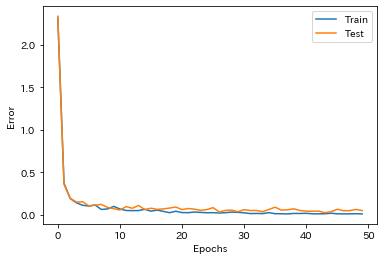

Accuracy Train: 100.0% Accuracy Test: 98.1636060100167%


In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- 手書き文字データセットの読み込み --
digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)

# -- 入力データの標準化 --
ave_input = np.average(input_data) # 平均
std_input = np.std(input_data) # 標準偏差
input_data = (input_data - ave_input) / std_input

# -- 正解をone-hot表現に --
correct_data = np.zeros((n_data, 10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

# -- 訓練データとテストデータ --
index = np.arange(n_data)
index_train = index[index%3 != 0]
index_test = index[index%3 == 0]

input_train = input_data[index_train, :]  # 訓練 入力
correct_train = correct_data[index_train, :]  # 訓練 正解
input_test = input_data[index_test, :]  # テスト 入力
correct_test = correct_data[index_test, :]  # テスト 正解

n_train = input_train.shape[0]  # 訓練データのサンプル数
n_test = input_test.shape[0]  # テストデータのサンプル数

# -- 各設定値 --
img_h = 8  # 入力画像の高さ
img_w = 8  # 入力画像の幅
img_ch = 1  # 入力画像のチャンネル数

wb_width = 0.1  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 50
batch_size = 8
interval = 10  # 経過の表示間隔
n_sample = 200  # 誤差計測のサンプル数

# -- im2col --
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
   
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]

    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

# -- col2im --
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
 
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w, ).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]

    return images[:, :, pad:img_h+pad, pad:img_w+pad]

# -- 畳み込み層 --
class ConvLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # n_flt:フィルタ数, flt_h:フィルタ高さ, flt_w:フィルタ幅
    # stride:ストライド幅, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):

        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # フィルタとバイアスの初期値
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        # 出力画像のサイズ
        self.y_ch = n_flt  # 出力チャンネル数
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  # 出力高さ
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1  # 出力幅
 
        # AdaGrad用
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像とフィルタを行列に変換
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        # 出力の計算: 行列積、バイアスの加算、活性化関数
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u) # 活性化関数にReluを使う
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # delta
        delta = grad_y * np.where(self.u <= 0, 0, 1) # 出力の勾配grad_y に Reluの微分系をかける
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch) # transposeとreshapeにより、deltaを行列に変形する
        
        # フィルタとバイアスの勾配
        grad_w = np.dot(self.cols, delta) # self.cols と deltaの行列積を求める
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w) # フィルタの勾配を求める
        self.grad_b = np.sum(delta, axis=0) # バイアスの勾配は、deltaにおける各列（フィルタに対応）の総和により求める
        
        # 入力の勾配
        grad_cols = np.dot(delta, self.w_col) # delta と 順伝播の際に求めたself.w_colの行列積により、colsの勾配を求めます
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad) # col2imgで画像の形状に変換し、入力の勾配 self.grad_x とする
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# -- プーリング層 --
class PoolingLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # pool:プーリング領域のサイズ, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        # 出力画像のサイズ
        self.y_ch = x_ch  # 出力チャンネル数
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1  # 出力高さ
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1  # 出力幅
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像を行列に変換
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad) # フィルタの幅と高さ、ストライドの幅にはプーリング領域のサイズを指定します
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool) # colsを、転置とreshapeにより、最大値をとるための形状に変換する
        
        # 出力の計算: Maxプーリング
        y = np.max(cols, axis=1) # 行列colsの、各行で最大値をとる
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2) # （B、C、y_h、 y_w）の4次元テンソルに変換する
        
        # 最大値のインデックスを保存
        self.max_index = np.argmax(cols, axis=1) # 各列の最大値のインデックスを、後に逆伝播で利用するために保存する
    
    def backward(self, grad_y): # grad_yの形状は（n_bt、y_ch、v_h、y_w）
        n_bt = grad_y.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 出力の勾配の軸を入れ替え。（n_bt、y_h、v_w、y_ch）の形状に変形
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        # 行列を作成
        # 行列colsの行数は、pool * pool、すなわちプーリング領域の全要素数とする
        # 行列colsの列数は、grad_y.size、すなわちgrad_yの全要素数とする
        grad_cols = np.zeros((pool*pool, grad_y.size))
        # 各列の最大値であった要素にのみ出力の勾配を入れる
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1) 
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        # grad_colsの形状を(y_ch、pool, pool, n_bt, y_h, y_w)に変形する
        grad_cols = grad_cols.transpose(5,0,1,2,3,4) 
        grad_cols = grad_cols.reshape( y_ch*pool*pool, n_bt*y_h*y_w)

        # 入力の勾配
        x_shape = (n_bt, x_ch, x_h, x_w)
        # grad_cols（行列）をcol2imで画像に戻して、入力の勾配self.grad_xとする
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)
         

# -- 全結合層の継承元 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros(( n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# -- 全結合 中間層 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # 活性化関数は、Relu
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

# -- 全結合 出力層 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1) # 活性化関数は、ソフトマックス関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 


# -- 各層の初期化 --
cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
pl_1 = PoolingLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
ml_1 = MiddleLayer(n_fc_in, 100)
ol_1 = OutputLayer(100, 10)

# -- 順伝播 --
def forward_propagation(x):
    n_bt = x.shape[0]
    
    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    pl_1.forward(cl_1.y)
    
    fc_input = pl_1.y.reshape(n_bt, -1)   
    ml_1.forward(fc_input)
    ol_1.forward(ml_1.y)

# -- 逆伝播 --
def backpropagation(t):
    n_bt = t.shape[0]
    
    ol_1.backward(t)
    ml_1.backward(ol_1.grad_x)
    
    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_1.backward(pl_1.grad_x)

# -- 重みとバイアスの更新 --
def uppdate_wb():
    cl_1.update(eta)
    ml_1.update(eta)
    ol_1.update(eta)

# -- 誤差を計算 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size # 損失関数は、交差エントロピー誤差

# -- サンプルを順伝播 --
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand) 
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x)
    return x, t

    
# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size
for i in range(epoch):

    # -- 誤差の計測 -- 
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)
    
    x, t = forward_sample(input_test, correct_test, n_sample) 
    error_test = get_error(t, n_sample)
    
    # -- 誤差の記録 -- 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    
    # -- 経過の表示 --
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
    
    # -- 学習 -- 
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)   
    for j in range(n_batch):
        
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        forward_propagation(x)
        backpropagation(t)        
        uppdate_wb() 
            
    
# -- 誤差の記録をグラフ表示 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
x, t = forward_sample(input_train, correct_train, n_train) 
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(input_test, correct_test, n_test) 
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")

## 画像判定の例

In [3]:
samples = input_test[:5]
forward_propagation(samples)
print(ol_1.y)
print(correct_test[:5])

[[9.99974313e-01 3.98107173e-10 4.17005766e-08 9.33510880e-09
  4.81431867e-07 1.40239354e-05 8.44257617e-09 4.56557285e-08
  1.17136713e-06 9.90444627e-06]
 [1.75277899e-08 2.81581923e-06 5.88326873e-06 9.98728187e-01
  3.41594908e-09 1.79168369e-04 6.02193076e-08 2.74724906e-07
  1.00102156e-04 9.83487322e-04]
 [1.21516841e-06 1.79119837e-05 3.23636565e-07 1.00618669e-08
  2.28980787e-06 3.32776340e-08 9.99867141e-01 2.93825720e-11
  1.11074564e-04 2.49499491e-12]
 [2.24660615e-04 3.39794866e-06 4.67765715e-08 5.38822849e-04
  1.84213866e-05 3.79132774e-01 1.69327987e-08 2.83596394e-05
  3.71436543e-03 6.16339134e-01]
 [1.52283333e-07 1.78933238e-02 9.81604186e-01 1.69252508e-04
  6.57325236e-06 5.88518654e-06 1.07364908e-06 5.02189431e-07
  3.14916001e-04 4.13461908e-06]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
